# **Heart Disease Prediction with Logistic Regression**

## Introduction

The **Heart Disease Cleveland dataset** (from the UCI ML Repository) is a benchmark in medical machine learning. It contains patient records with 14 clinically relevant features such as age, sex, chest pain type, blood pressure, cholesterol, and ECG results.

The **target variable** indicates heart disease presence:

* **0** → No disease
* **1–4** → Disease present

We frame this as a **binary classification** problem: predicting whether a patient has heart disease (**1–4**) or not (**0**).

The dataset contains missing values, so preprocessing is required.

Our objective is to build and compare two **Logistic Regression** approaches:

1. **From Scratch** → Manual implementation using Gradient Descent.
2. **With Scikit-Learn** → Using `LogisticRegression` from sklearn.

By the end, we will:

* Preprocess and explore the dataset.
* Train and evaluate both models.
* Compare performance (accuracy, confusion matrix, decision boundaries).

This project demonstrates how Logistic Regression can be applied to real-world medical data while deepening our understanding of the algorithm itself.

---

## **Data Overview**

### Libraries 

In [1]:
import numpy as np
import pandas as pd
import copy, math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc


### Data Loading

In [2]:
df = pd.read_csv("processed.cleveland.data", header=None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
              'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 
              'ca', 'thal', 'target']
# Replace missing values (marked as '?')
df = df.replace('?', pd.NA)

# Convert to numeric
df = df.apply(pd.to_numeric)

print(df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  




`target` ranges from `0–4`. Usually, heart disease prediction is **binary**:

      0 = no disease
      1, 2, 3, 4 = disease present
      Solution: Map to binary

In [3]:
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
print("Shape of dataset:", df.shape)

print("\nInfo:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values per Column:")
print(df.isnull().sum())

Shape of dataset: (303, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None

Summary Statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000

### **Exploratory Data Analysis (Before Preprocessing)**
### Target Class Distribution

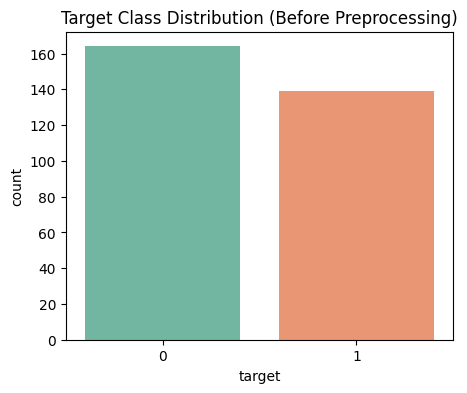

In [5]:
plt.figure(figsize=(5,4))
sns.countplot(x="target", hue="target", data=df, palette="Set2", legend=False)
plt.title("Target Class Distribution (Before Preprocessing)")
plt.show()

### Feature Distributions (Numeric Features)

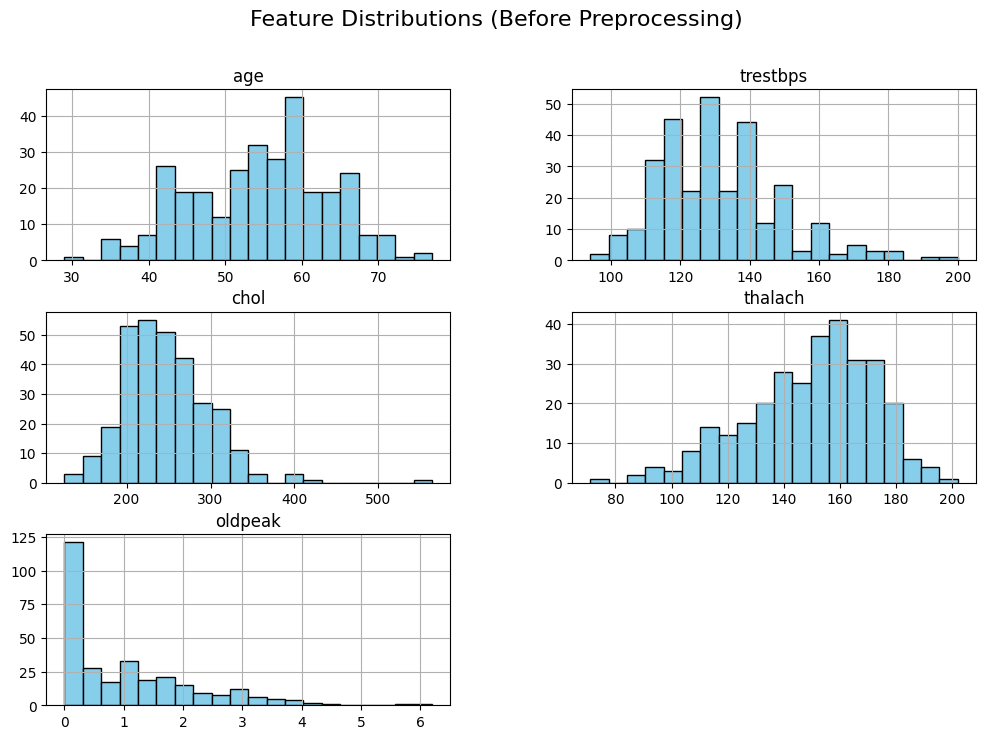

In [6]:
num_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
df[num_cols].hist(bins=20, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions (Before Preprocessing)", fontsize=16)
plt.show()


### Correlation Heatmap

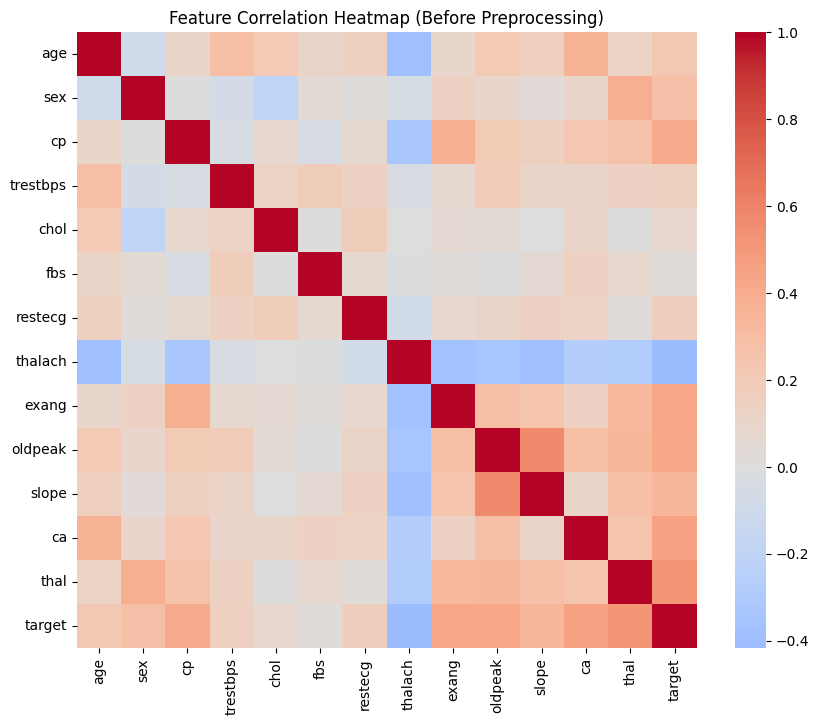

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Before Preprocessing)")
plt.show()


## **Data Preprocessing**

Impute missing values in **ca** and **thal** with mode

In [8]:
df['ca'] = df['ca'].fillna(df['ca'].mode()[0])
df['thal'] = df['thal'].fillna(df['thal'].mode()[0])

 **One-hot encode** multi-class categorical variables

In [9]:
categorical_multi = ['cp', 'restecg', 'slope', 'ca', 'thal']
df = pd.get_dummies(df, columns=categorical_multi, drop_first=True)

Separate features **(X)** and target **(y)**

In [10]:
X = df.drop("target", axis=1)
y = df["target"]

**Train-test split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

 Scale features using **StandardScaler**

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Logistic Regression from Scratch**

### 1. Understanding Logistic Regression

* Logistic Regression is a **classification algorithm**.
* Instead of predicting continuous values (like Linear Regression), it predicts **probabilities between 0 and 1**.
* It uses the **sigmoid function** to map predictions into probabilities.

### Formula for sigmoid:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Where:

* $z = w^T x + b$
* $w$ = weights, $b$ = bias, $x$ = input features.





In [13]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

### 2. Hypothesis Function

* Our model predicts:

$$
\hat{y} = \sigma(w^T x + b)
$$

* Output $\hat{y}$ is the probability that the target = 1.


In [14]:
def f_wb(x, w, b):
    return sigmoid(np.dot(x,w) + b)

### 3. Loss Function (Binary Cross-Entropy)

* To measure error, we use **Log Loss**:

$$
L(y, \hat{y}) = - \Big( y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \Big)
$$

* For the full dataset (m samples):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} L(y^{(i)}, \hat{y}^{(i)})
$$




In [15]:
def compute_cost_logistic(X, y, w, b):
     m = X.shape[0]
    
     cost_sum = 0
     for i in range(m):
         f_wb_i = f_wb(X[i], w, b)
         log_loss = -(y[i]*np.log(f_wb_i) + (1 - y[i])*np.log(1 - f_wb_i) )
         cost_sum = cost_sum + log_loss
     total_cost = (1/m)*cost_sum
    
     return total_cost

### 4. Logistic Gradient Descent

Recall the gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$


In [16]:
def compute_gradient_logistic(X, y, w, b):
    m,n = X.shape
    dj_dw = np.zeros((n,))                           
    dj_db = 0.

    for i in range(m):
        f_wb_i = f_wb(X[i], w, b)        
        err_i  = f_wb_i  - y[i]                       
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   
        
    return dj_db, dj_dw  

### Update Rules:

$$
w := w - \alpha \frac{\partial J}{\partial w}
$$

$$
b := b - \alpha \frac{\partial J}{\partial b}
$$

Where $\alpha$ is the **learning rate**.

In [17]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
   
    J_history = []
    w = copy.deepcopy(w_in)  
    b = b_in
    
    for i in range(num_iters):
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        if i<100000:      
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 100 times 
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         

### 5. Prediction Rule

* After training, we use a threshold (commonly 0.5):

$$
\hat{y}_{pred} =
\begin{cases} 
1 & \text{if } \hat{y} \geq 0.5 \\
0 & \text{if } \hat{y} < 0.5
\end{cases}
$$


In [18]:
def predict(X, w, b, threshold=0.5):
    
    m = X.shape[0]
    y_pred = np.zeros(m)

    for i in range(m):
        f_wb_i = f_wb(X[i], w, b)
        y_pred[i] = 1 if f_wb_i >= threshold else 0

    return y_pred


### 6. Train Model

We use our `gradient_descent` function to optimize weights and bias.

In [19]:
w_init = np.zeros(X_train.shape[1])
b_init = 0
alpha = 0.01
num_iters = 10000

w_final, b_final, J_hist = gradient_descent(X_train_scaled, y_train.values, w_init, b_init, alpha, num_iters)

print("\nFinal Weights:", w_final)
print("Final Bias:", b_final)


Iteration    0: Cost 0.6891008271414181   
Iteration 1000: Cost 0.35151041279764916   
Iteration 2000: Cost 0.3384366037522676   
Iteration 3000: Cost 0.3337687413538098   
Iteration 4000: Cost 0.33139438047873687   
Iteration 5000: Cost 0.32998238656840284   
Iteration 6000: Cost 0.3290749504609155   
Iteration 7000: Cost 0.32846642091611605   
Iteration 8000: Cost 0.3280475703879558   
Iteration 9000: Cost 0.32775412078926275   

Final Weights: [-0.09529415  0.77058295  0.40241642  0.21085692 -0.09634198 -0.39552489
  0.25527224  0.24395367  0.36577756 -0.01301294  0.92024561 -0.14033222
  0.18649559  0.65266984  0.06444496  0.88938924  0.86929389  0.60546214
 -0.00775738  0.7213934 ]
Final Bias: -0.1345633643975392


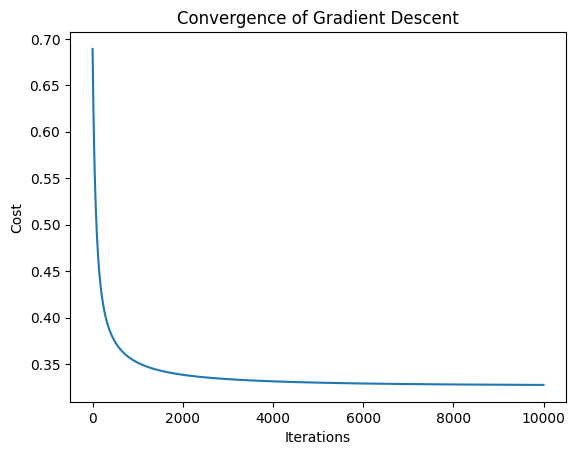

In [20]:
plt.plot(J_hist)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Convergence of Gradient Descent")
plt.show()

### 7. Make Predictions
* **Training predictions:** To see how well your model learned the training data:


In [21]:
y_train_pred = predict(X_train_scaled, w_final, b_final)

* **Testing predictions:** To see how well your model generalizes to unseen data:

In [22]:
y_test_pred  = predict(X_test_scaled, w_final, b_final)

### 8. Model Evaluation

- Accuracy:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}
$$

- Confusion Matrix
- Precision, Recall, F1-score

In [23]:
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Confusion Matrix
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))

# Precision, Recall, F1
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

Train Accuracy: 0.8760330578512396
Test Accuracy: 0.8524590163934426

Confusion Matrix (Test):
 [[28  5]
 [ 4 24]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



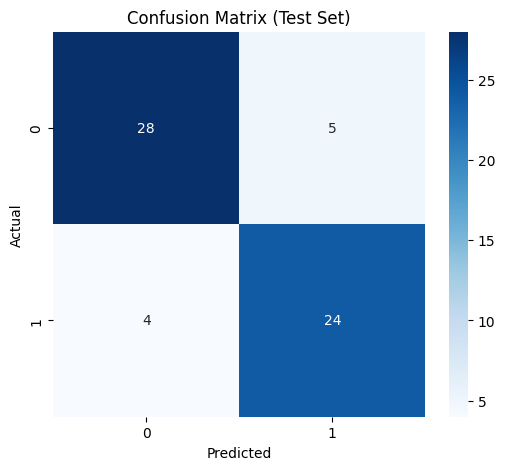

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()


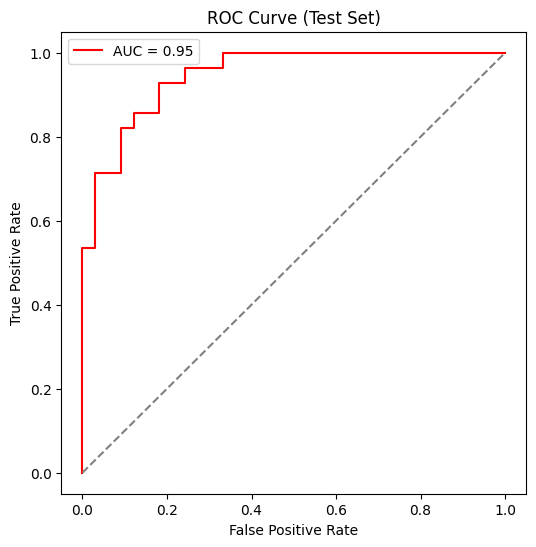

In [25]:

# Compute predicted probabilities
y_test_proba = np.array([f_wb(x, w_final, b_final) for x in X_test_scaled])
y_test_proba = 1 / (1 + np.exp(-y_test_proba))  # sigmoid

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='red', label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()


## **Logistic Regression with scikit-learn**

We will implement **Logistic Regression** using scikit-learn, which simplifies training, prediction, and evaluation.
The key steps are:

1. **Train the model on the training set**

In [26]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

lr_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


2. **Predict on the test set**


In [27]:
y_train_pred_sk = lr_model.predict(X_train_scaled)
y_test_pred_sk = lr_model.predict(X_test_scaled)

3. **Evaluate performance** using accuracy, confusion matrix, and classification report

In [28]:
train_acc = accuracy_score(y_train, y_train_pred_sk)
test_acc = accuracy_score(y_test, y_test_pred_sk)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

cm_sk = confusion_matrix(y_test, y_test_pred_sk)
print("\nConfusion Matrix (Test):\n", cm_sk)

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_sk))

Train Accuracy: 0.8678
Test Accuracy: 0.8525

Confusion Matrix (Test):
 [[28  5]
 [ 4 24]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



4. **Visualization:** scikit-learn Logistic Regression


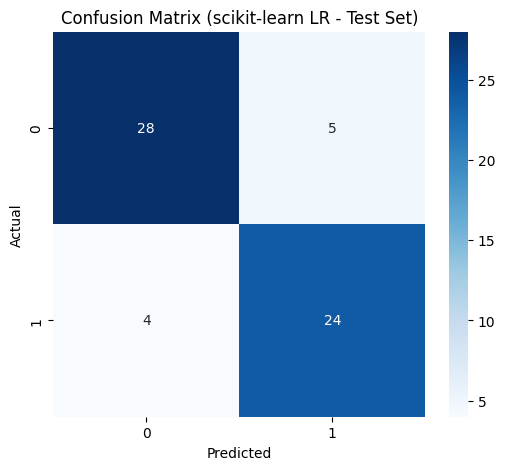

In [29]:
cm_sk = confusion_matrix(y_test, y_test_pred_sk)

plt.figure(figsize=(6,5))
sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (scikit-learn LR - Test Set)")
plt.show()



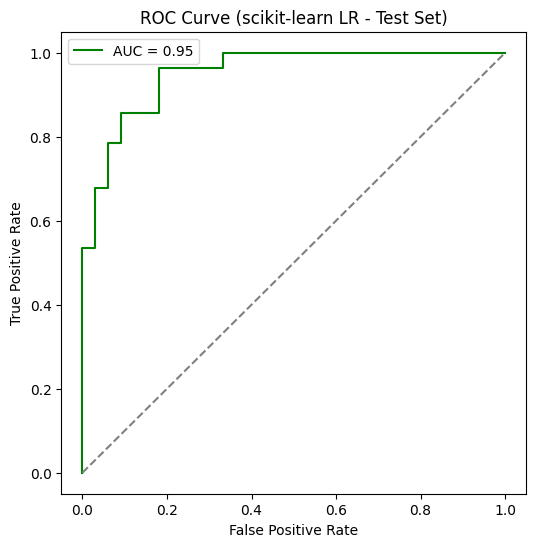

In [30]:
# Compute predicted probabilities
y_test_proba_sk = lr_model.predict_proba(X_test_scaled)[:,1]  # probability of class 1

fpr_sk, tpr_sk, thresholds_sk = roc_curve(y_test, y_test_proba_sk)
roc_auc_sk = auc(fpr_sk, tpr_sk)

plt.figure(figsize=(6,6))
plt.plot(fpr_sk, tpr_sk, color='green', label=f"AUC = {roc_auc_sk:.2f}")
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (scikit-learn LR - Test Set)")
plt.legend()
plt.show()

## **Comparison: Scratch vs scikit-learn Logistic Regression**

We will compare the **performance** of our logistic regression model implemented from scratch with **scikit-learn’s** implementation.

**Metrics to compare:**

* Train Accuracy
* Test Accuracy
* Confusion Matrix (Test)
* ROC Curve / AUC
* F1-Score, Precision, Recall


In [31]:
comparison_data = {
    "Model": ["Scratch LR", "scikit-learn LR"],
    "Train Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_train, y_train_pred_sk)
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, y_test_pred_sk)
    ],
    "Precision": [
        precision_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred_sk)
    ],
    "Recall": [
        recall_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred_sk)
    ],
    "F1-Score": [
        f1_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred_sk)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,Scratch LR,0.876033,0.852459,0.827586,0.857143,0.842105
1,scikit-learn LR,0.867769,0.852459,0.827586,0.857143,0.842105


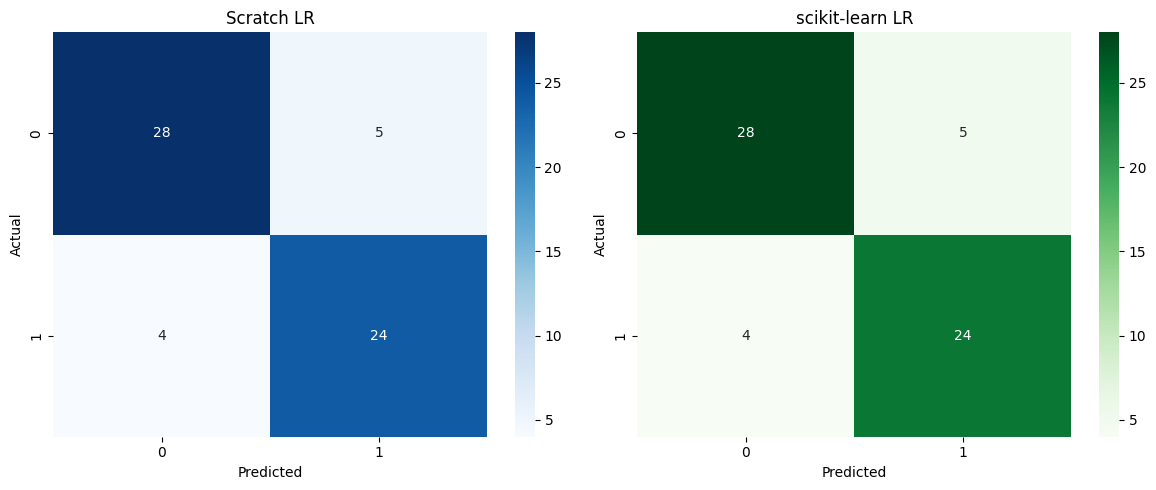

In [32]:
# Confusion Matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Scratch LR")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_test_pred_sk), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("scikit-learn LR")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


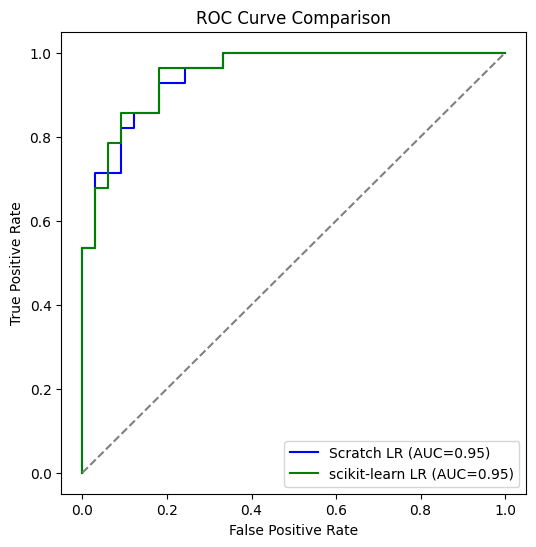

In [33]:
# ROC Curves side by side
y_test_proba_scratch = 1 / (1 + np.exp(-np.array([f_wb(x, w_final, b_final) for x in X_test_scaled])))
y_test_proba_sklearn = lr_model.predict_proba(X_test_scaled)[:,1]

plt.figure(figsize=(6,6))
fpr_scratch, tpr_scratch, _ = roc_curve(y_test, y_test_proba_scratch)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_test_proba_sklearn)

plt.plot(fpr_scratch, tpr_scratch, label=f"Scratch LR (AUC={auc(fpr_scratch, tpr_scratch):.2f})", color='blue')
plt.plot(fpr_sklearn, tpr_sklearn, label=f"scikit-learn LR (AUC={auc(fpr_sklearn, tpr_sklearn):.2f})", color='green')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()